In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

In [2]:
dayDf = pd.read_csv('day.csv')
dayDf.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
dayDf.shape

(730, 16)

In [4]:
dayDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


- Some columns are categorical (mnth, season, weekday and weathersit)
- Can drop columns like instant, dteday, casual, registered as they are irrelevant/redundant

**Data Visualiztion**

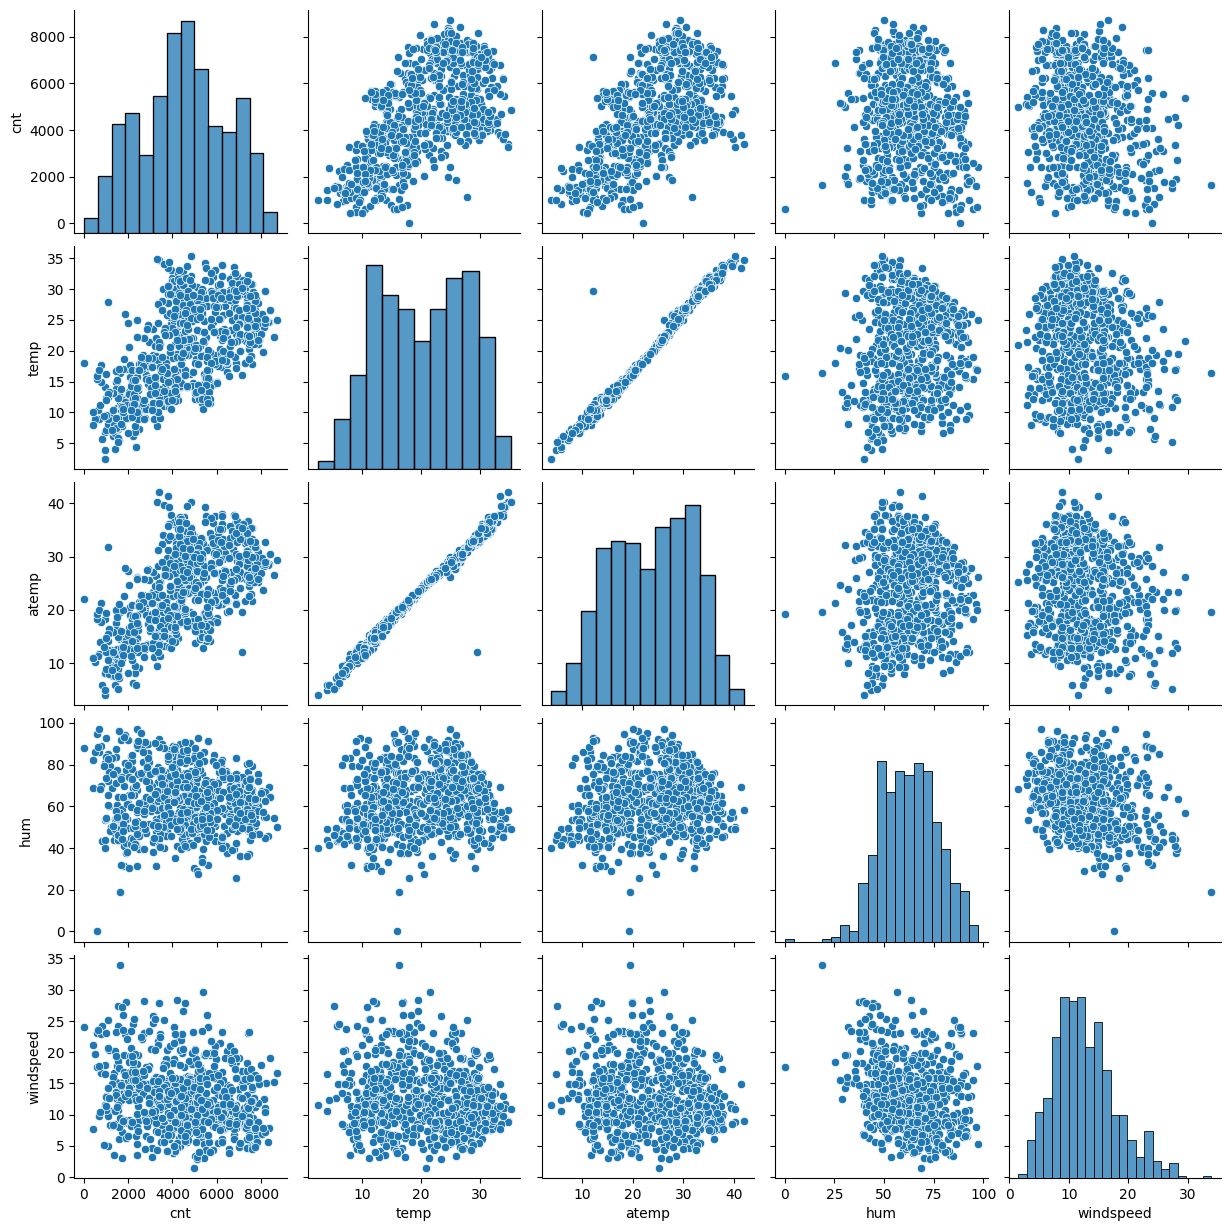

<Figure size 1000x1000 with 0 Axes>

In [5]:
#Numerical
sns.pairplot(data=dayDf, vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
plt.figure(figsize=(10,10))
plt.show()

We can consider a linear model in this case because there are few independent variables that has a positive correlation with cnt .


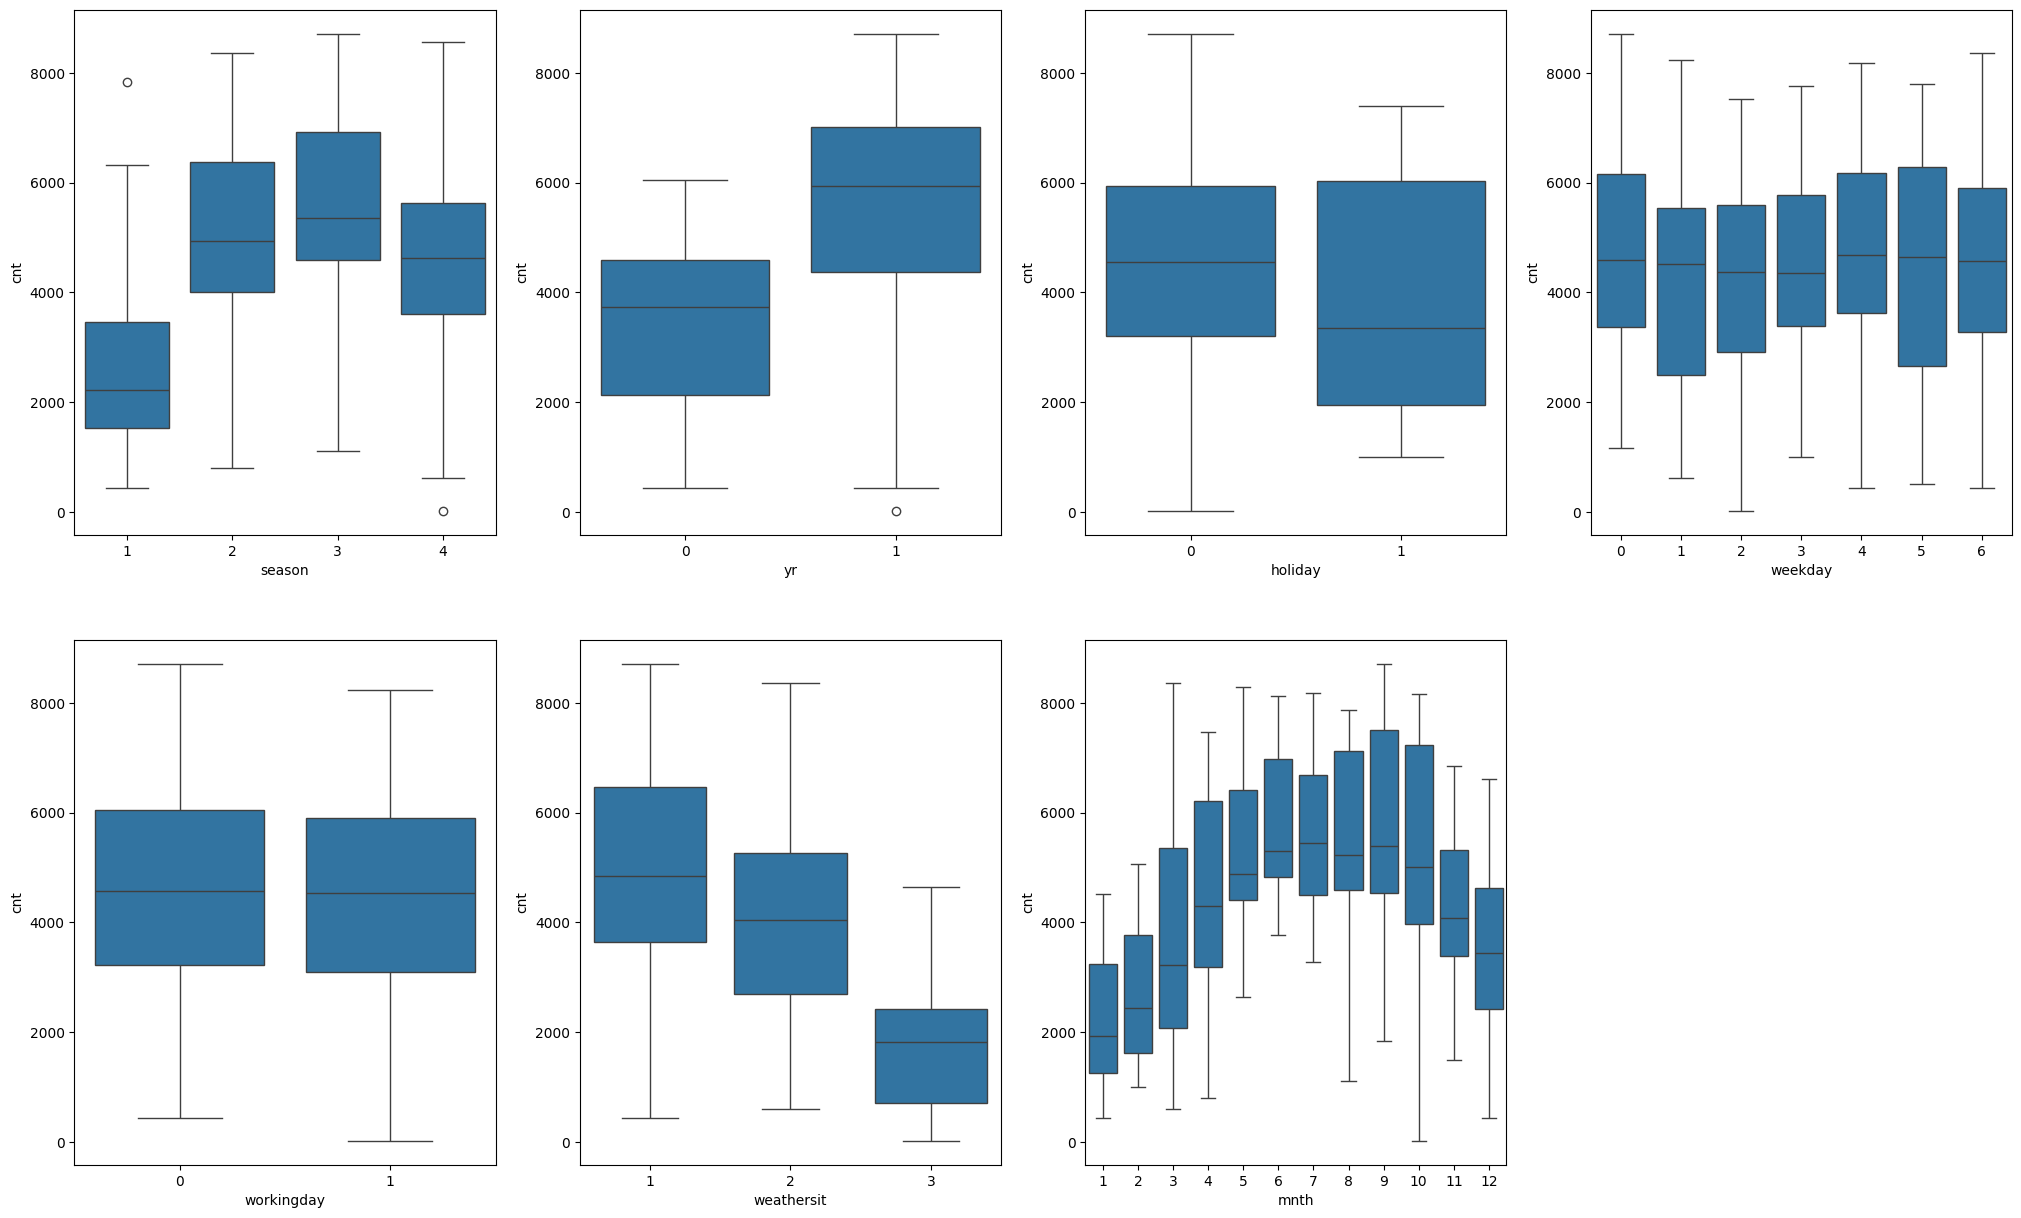

In [6]:
#Categorical
plt.figure(figsize=(25, 15))
plt.subplot(2,4,1)
sns.boxplot(x = 'season', y = 'cnt', data = dayDf)
plt.subplot(2,4,2)
sns.boxplot(x = 'yr', y = 'cnt', data = dayDf)
plt.subplot(2,4,3)
sns.boxplot(x = 'holiday', y = 'cnt', data = dayDf)
plt.subplot(2,4,4)
sns.boxplot(x = 'weekday', y = 'cnt', data = dayDf)
plt.subplot(2,4,5)
sns.boxplot(x = 'workingday', y = 'cnt', data = dayDf)
plt.subplot(2,4,6)
sns.boxplot(x = 'weathersit', y = 'cnt', data = dayDf)
plt.subplot(2,4,7)
sns.boxplot(x = 'mnth', y = 'cnt', data = dayDf)
plt.show()

- For the variable season,the category 3 : Fall, has the highest median, and is least for 1: spring.
- Count of users increased from 2018 to 2019.
- There are no users when there is heavy rain/ snow. Highest when the weather situation was Clear, Partly Cloudy.
- From the "Workingday" boxplot we can see those maximum bookings are between 4000 and 6000, and the median count of the users is same almost all the week and working day or not.

**Data Cleaning**

In [7]:
#Checking missing values
dayDf.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

- No missing values found.

Removing columns which are not needed
- instant as it is a serial number
- dteday since mnth and yr columns are sufficient

In [8]:
dayDf = dayDf.drop(['instant','dteday'],axis =1)

In [9]:
#Encoding 4 categories of season using get_dummies()
season = pd.get_dummies(dayDf['season'], dtype=int)

In [10]:
season.head()

,1,2,3,4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [11]:
#renaming to spring, summer, fall, winter
season1 = season.rename(columns={1:'spring', 2:'summer', 3:'fall', 4:'winter'},inplace = False)
season1.sample(5)

,spring,summer,fall,winter
17,1,0,0,0
338,0,0,0,1
69,1,0,0,0
288,0,0,0,1
170,0,1,0,0


Converting 4 columns for season into 3 dummy variables

- 000 - spring
- 100 - summer
- 010 - fall
- 001 - winter

In [12]:
season1 = season1.drop(['spring'],axis=1)

In [13]:
#concat season1 to dayDf
dayDf = pd.concat((dayDf,season1),axis=1)

In [14]:
dayDf = dayDf.drop(['season'],axis=1)
dayDf.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,summer,fall,winter
0,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985,0,0,0
1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801,0,0,0
2,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0,0,0
3,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0,0,0
4,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0,0,0


In [15]:
#mnth feature
mon = pd.get_dummies(dayDf['mnth'], dtype=int)
mon.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [16]:
mon1 = mon.rename(columns={ 1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'},inplace = False)
mon1.head(5)

,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [17]:
dayDf = pd.concat((dayDf,mon1),axis=1)

In [18]:
#Since 12 months can be explained by 11 dummy variables
dayDf = dayDf.drop(['mnth','Jan'],axis=1)
dayDf.sample(5)

,yr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,...,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
645,1,1,2,0,2,15.716653,19.38040,70.9583,12.708493,874,...,0,0,0,0,0,0,0,1,0,0
234,0,0,4,1,1,26.274153,30.30335,45.5417,9.833121,1281,...,0,0,0,0,0,1,0,0,0,0
415,1,1,3,0,1,11.480000,13.66955,50.7826,15.348561,502,...,0,0,0,0,0,0,0,0,0,0
176,0,0,2,1,1,27.880000,31.88145,51.3333,6.333731,1920,...,0,0,0,1,0,0,0,0,0,0
286,0,0,0,0,2,22.584153,26.48375,71.6250,15.000161,529,...,0,0,0,0,0,0,0,1,0,0


In [19]:
dayDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   weekday     730 non-null    int64  
 3   workingday  730 non-null    int64  
 4   weathersit  730 non-null    int64  
 5   temp        730 non-null    float64
 6   atemp       730 non-null    float64
 7   hum         730 non-null    float64
 8   windspeed   730 non-null    float64
 9   casual      730 non-null    int64  
 10  registered  730 non-null    int64  
 11  cnt         730 non-null    int64  
 12  summer      730 non-null    int64  
 13  fall        730 non-null    int64  
 14  winter      730 non-null    int64  
 15  Feb         730 non-null    int64  
 16  Mar         730 non-null    int64  
 17  Apr         730 non-null    int64  
 18  May         730 non-null    int64  
 19  June        730 non-null    i

Holiday feature has only 2 values
- 0 - not holiday
- 1 - holiday

So no need to encode again

In [20]:
#weekday
weekday = pd.get_dummies(dayDf['weekday'], dtype=int)
weekday.head()

,0,1,2,3,4,5,6
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0


In [21]:
week1 = weekday.rename(columns={0:'Sunday', 1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thrusday',5:'Friday',6:'Saturday'},inplace = False)
week1.head()

,Sunday,Monday,Tuesday,Wednesday,Thrusday,Friday,Saturday
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0


In [22]:
dayDf = pd.concat((dayDf,week1),axis=1)

In [23]:
#Dropping Sunday since 6 dummy variable can explain 7 categories
dayDf = dayDf.drop(['weekday','Sunday'],axis=1)
dayDf.sample(5)

,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,...,Sep,Oct,Nov,Dec,Monday,Tuesday,Wednesday,Thrusday,Friday,Saturday
24,0,0,1,2,9.162598,11.72630,61.6957,8.696332,186,1799,...,0,0,0,0,0,0,0,1,0,0
259,0,0,1,2,20.158347,23.92560,71.8333,12.708225,1434,3077,...,1,0,0,0,1,0,0,0,0,0
243,0,0,0,1,26.855000,30.74605,63.9167,9.500332,783,4332,...,1,0,0,0,0,0,0,0,0,1
728,1,0,1,1,10.489153,11.58500,48.3333,23.500518,364,1432,...,0,0,0,1,1,0,0,0,0,0
270,0,0,1,2,26.035000,28.75790,84.8750,9.958143,480,3427,...,1,0,0,0,0,0,0,0,1,0


workingday feature has only 2 values

- 1 - if day is neither weekend nor holiday
- 0 - otherwise

So no need to encode again

In [24]:
#Weathersit
weathersit = pd.get_dummies(dayDf['weathersit'], dtype=int)
weathersit.head()

,1,2,3
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [25]:
weathersit1 = weathersit.rename(columns = {1:'Clear' ,2: 'Mist' , 3: 'Light'},inplace = False)
weathersit1.head()

,Clear,Mist,Light
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [26]:
dayDf = pd.concat((dayDf,weathersit1), axis =1)
dayDf = dayDf.drop('weathersit',axis=1)
dayDf.sample(5)

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,Dec,Monday,Tuesday,Wednesday,Thrusday,Friday,Saturday,Clear,Mist,Light
469,1,0,1,24.873347,28.69375,50.7917,15.083643,2846,4286,7132,...,0,1,0,0,0,0,0,1,0,0
555,1,0,1,29.554153,33.23980,66.7500,10.166379,954,5336,6290,...,0,0,0,1,0,0,0,0,1,0
243,0,0,0,26.855000,30.74605,63.9167,9.500332,783,4332,5115,...,0,0,0,0,0,0,1,1,0,0
584,1,0,1,30.750000,35.38585,67.2917,7.416900,1263,6271,7534,...,0,0,0,0,1,0,0,0,1,0
640,1,0,1,26.957500,29.95665,79.3750,4.458569,728,6844,7572,...,0,0,0,0,1,0,0,0,1,0


In [27]:
dayDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   temp        730 non-null    float64
 4   atemp       730 non-null    float64
 5   hum         730 non-null    float64
 6   windspeed   730 non-null    float64
 7   casual      730 non-null    int64  
 8   registered  730 non-null    int64  
 9   cnt         730 non-null    int64  
 10  summer      730 non-null    int64  
 11  fall        730 non-null    int64  
 12  winter      730 non-null    int64  
 13  Feb         730 non-null    int64  
 14  Mar         730 non-null    int64  
 15  Apr         730 non-null    int64  
 16  May         730 non-null    int64  
 17  June        730 non-null    int64  
 18  July        730 non-null    int64  
 19  Aug         730 non-null    i

In [28]:
dayDf.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,Dec,Monday,Tuesday,Wednesday,Thrusday,Friday,Saturday,Clear,Mist,Light
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,...,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.690411,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849,...,0.084932,0.143836,0.143836,0.142466,0.142466,0.142466,0.142466,0.634247,0.336986,0.028767
std,0.500343,0.167266,0.462641,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647,...,0.278971,0.351164,0.351164,0.349767,0.349767,0.349767,0.349767,0.481971,0.473004,0.167266
min,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


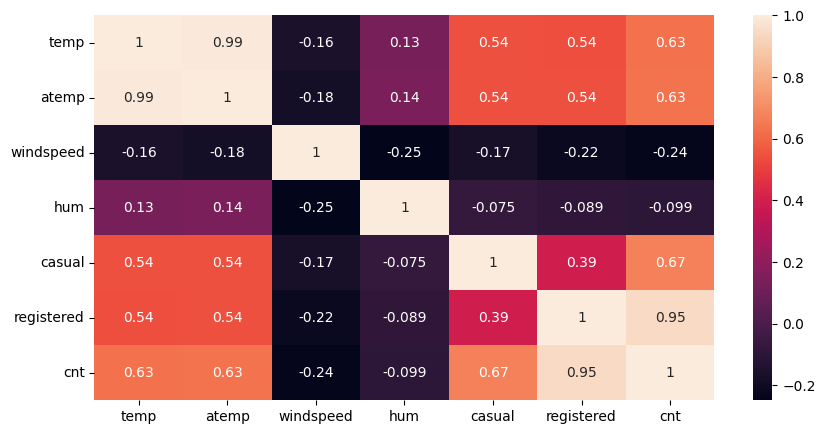

In [29]:
#Visualization against cnt
plt.figure(figsize = (10,5))
sns.heatmap(dayDf[["temp",'atemp', 'windspeed',"hum",'casual','registered','cnt']].corr(),annot =True)
plt.show()

- Registered Bike users are strongly correlated to cnt.
- Temp and atemp are very strongly correlated, so one can be dropped.
- Humidity is not much correlated to cnt.

Only after renting a bike, we can know if the user rented it casually or registered to it, so we can drop this.

In [30]:
dayDf = dayDf.drop(['atemp','casual','registered'],axis =1)

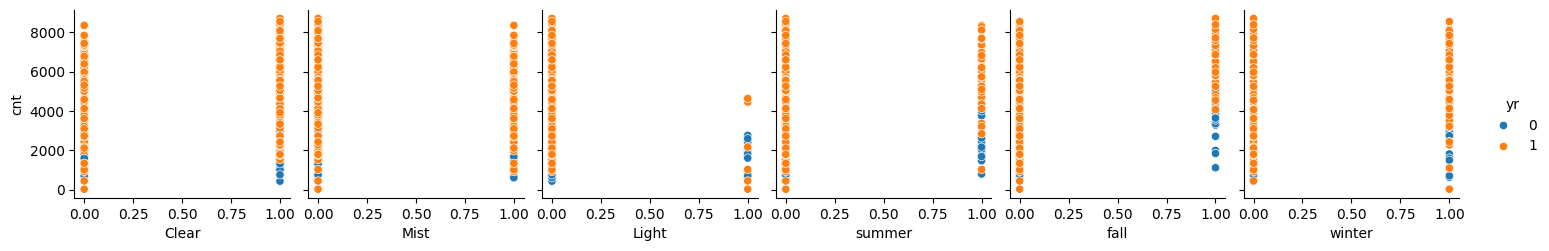

In [31]:
sns.pairplot(dayDf,x_vars =['Clear', 'Mist','Light','summer','fall','winter'],y_vars='cnt',hue ='yr')
plt.show()

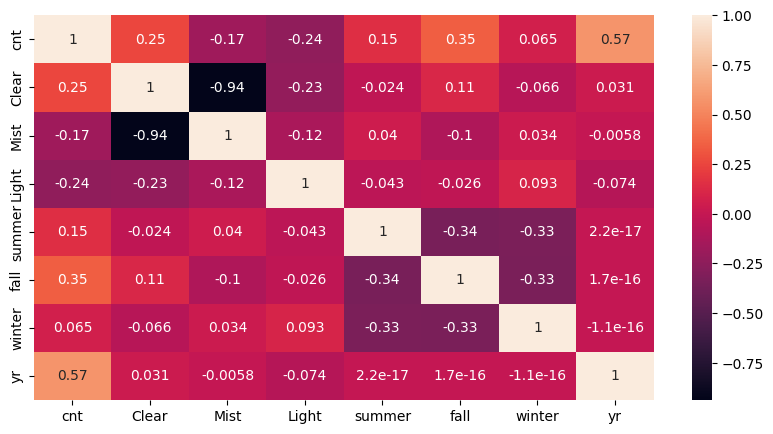

In [32]:
plt.figure(figsize = (10,5))
sns.heatmap(dayDf[['cnt','Clear', 'Mist','Light','summer','fall','winter','yr']].corr(),annot =True)
plt.show()

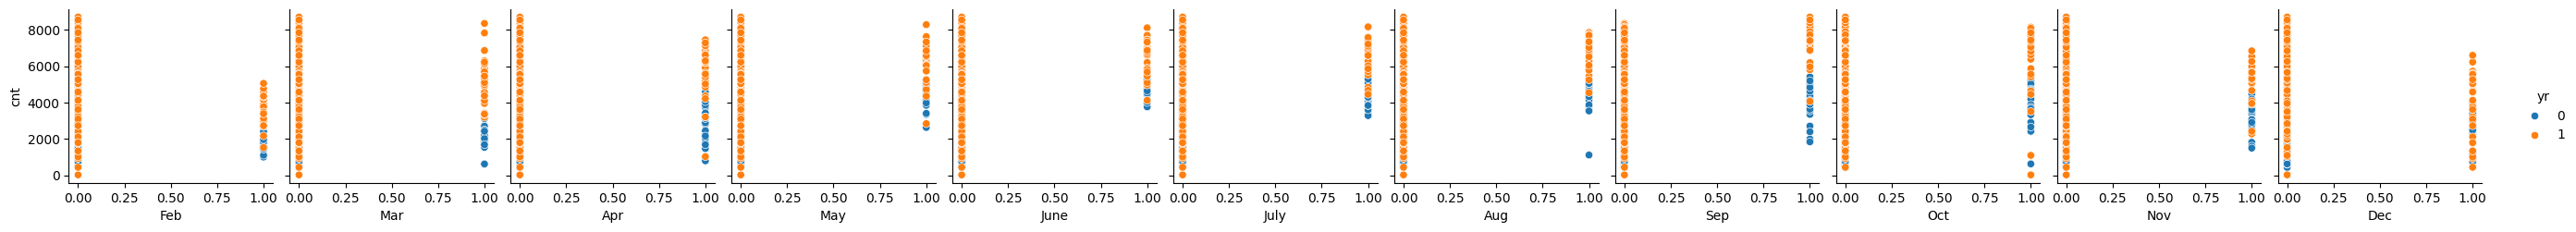

In [33]:
sns.pairplot(dayDf,x_vars =['Feb','Mar','Apr','May','June','July' ,'Aug','Sep','Oct','Nov','Dec'],y_vars='cnt',hue ='yr')
plt.show()

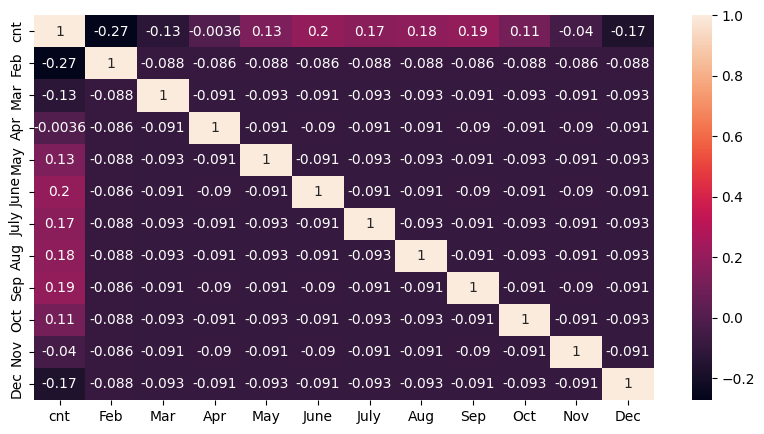

In [34]:
plt.figure(figsize = (10,5))
sns.heatmap(dayDf[['cnt','Feb','Mar','Apr','May','June','July' ,'Aug','Sep','Oct','Nov','Dec']].corr(),annot = True)
plt.show()

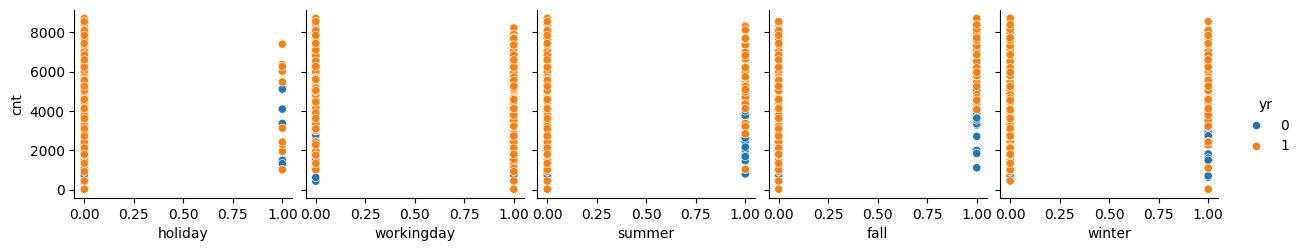

In [35]:
sns.pairplot(dayDf,x_vars =['holiday', 'workingday','summer','fall','winter'],y_vars='cnt',hue ='yr')
plt.show()

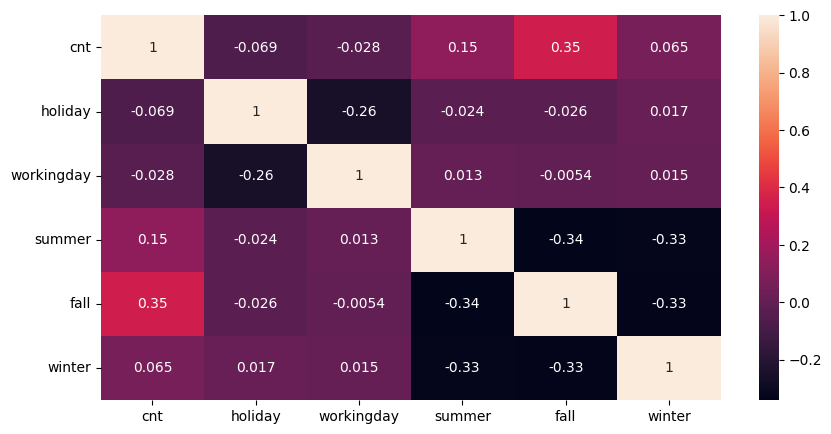

In [36]:
plt.figure(figsize = (10,5))
sns.heatmap(dayDf[['cnt','holiday', 'workingday','summer','fall','winter']].corr(),annot = True)
plt.show()

- Most no. of bikes are rented in winters.
- No. of bikes rented increased from 2018 to 2019.

**Data Modelling**

In [37]:
df_train, df_test = train_test_split(dayDf, train_size = 0.7, test_size = 0.3, random_state = 100)

In [38]:
print(df_train.shape)
print(df_test.shape)

(510, 30)
(219, 30)


In [39]:
# using MinMaxScaler
scaler = MinMaxScaler()

# For scaling
num_vars = ['temp', 'windspeed',"hum",'cnt']

# fit transform training data
df_train[num_vars]=scaler.fit_transform(df_train[num_vars])
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,summer,fall,winter,...,Dec,Monday,Tuesday,Wednesday,Thrusday,Friday,Saturday,Clear,Mist,Light
653,1,0,1,0.509887,0.575354,0.300794,0.864243,0,0,1,...,0,0,0,1,0,0,0,1,0,0
576,1,0,1,0.815169,0.725633,0.264686,0.827658,0,1,0,...,0,0,0,1,0,0,0,1,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.465255,0,0,0,...,0,0,0,0,0,0,0,0,1,0
728,1,0,1,0.245101,0.498067,0.663106,0.204096,0,0,0,...,1,1,0,0,0,0,0,1,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.482973,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [40]:
y_train = df_train.pop('cnt')
X_train = df_train

**RFE**

In [41]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm,n_features_to_select=15) # running RFE
rfe = rfe.fit(X_train, y_train)

In [42]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', np.True_, np.int64(1)),
 ('holiday', np.True_, np.int64(1)),
 ('workingday', np.False_, np.int64(5)),
 ('temp', np.True_, np.int64(1)),
 ('hum', np.True_, np.int64(1)),
 ('windspeed', np.True_, np.int64(1)),
 ('summer', np.True_, np.int64(1)),
 ('fall', np.True_, np.int64(1)),
 ('winter', np.True_, np.int64(1)),
 ('Feb', np.False_, np.int64(11)),
 ('Mar', np.True_, np.int64(1)),
 ('Apr', np.False_, np.int64(3)),
 ('May', np.False_, np.int64(2)),
 ('June', np.False_, np.int64(4)),
 ('July', np.False_, np.int64(12)),
 ('Aug', np.True_, np.int64(1)),
 ('Sep', np.True_, np.int64(1)),
 ('Oct', np.True_, np.int64(1)),
 ('Nov', np.False_, np.int64(14)),
 ('Dec', np.False_, np.int64(13)),
 ('Monday', np.False_, np.int64(9)),
 ('Tuesday', np.False_, np.int64(10)),
 ('Wednesday', np.False_, np.int64(8)),
 ('Thrusday', np.False_, np.int64(6)),
 ('Friday', np.False_, np.int64(7)),
 ('Saturday', np.False_, np.int64(15)),
 ('Clear', np.True_, np.int64(1)),
 ('Mist', np.True_, np.int64(1)),
 

In [43]:
# Selecting Features on RFE
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'summer', 'fall', 'winter',
       'Mar', 'Aug', 'Sep', 'Oct', 'Clear', 'Mist', 'Light'],
      dtype='object')

In [44]:
# Rejected Features on RFE
X_train.columns[~(rfe.support_)]

Index(['workingday', 'Feb', 'Apr', 'May', 'June', 'July', 'Nov', 'Dec',
       'Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday'],
      dtype='object')

**Model building using Statsmodel**

In [45]:
# Creating X train dataframe with RFE Selected Variables
X_train_rfe = X_train[col]

In [46]:
# Adding a constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

In [47]:
# Creating Linear Model object
lm = sm.OLS(y_train, X_train_rfe).fit()

# Summary
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     192.2
Date:                Sat, 28 Sep 2024   Prob (F-statistic):          9.02e-190
Time:                        23:17:00   Log-Likelihood:                 513.33
No. Observations:                 510   AIC:                            -996.7
Df Residuals:                     495   BIC:                            -933.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0984      0.024      4.056      0.000       0.051       0.146
yr             0.2297      0.008     28.400      0.000       0.214       0.246
holiday       -0.0903      0.025     -3.543      0.000      -0.140      -0.040
temp           0.4952      0.034     14.582      0.000       0.428       0.562
hum           -0.1702      0.038     -4.519      0.000      -0.244      -0.096
windspeed     -0.1857      0.026     -7.241      0.000      -0.236      -0.135
summer         0.1217      0.015      8.090      0.000       0.092       0.151
fall           0.0366      0.023      1.618      0.106      -0.008       0.081
winter         0.1504      0.014     10.700      0.000       0.123       0.178
Mar            0.0285      0.014      1.975      0.049       0.000       0.057
Aug            0.0506      0.017      2.897      0.004       0.016       0.085
Sep            0.1204      0.017      6.966      0.000       0.086       0.154
Oct            0.0421      0.017      2.414      0.016       0.008       0.076
Clear          0.1337      0.008     15.844      0.000       0.117       0.150
Mist           0.0777      0.011      6.926      0.000       0.056       0.100
Light         -0.1130      0.022     -5.172      0.000      -0.156      -0.070
==============================================================================
Omnibus:                       72.046   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.620
Skew:                          -0.742   Prob(JB):                     1.47e-37
Kurtosis:                       5.404   Cond. No.                     2.01e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.61e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [48]:
# Calculating  VIF
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values,i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
15,Light,inf
13,Clear,inf
14,Mist,inf
7,fall,6.29
3,temp,3.72
6,summer,2.65
8,winter,2.34
4,hum,1.91
10,Aug,1.68
12,Oct,1.52


In [49]:
#Dropping Clear column as VIF is inf
X_train_rfe = X_train_rfe.drop('Clear',axis=1)

In [50]:
# Adding a constant variable
X_train_sm = sm.add_constant(X_train_rfe)
# Creating Linear Model object
lm = sm.OLS(y_train, X_train_sm).fit()
# Summary
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     192.2
Date:                Sat, 28 Sep 2024   Prob (F-statistic):          9.02e-190
Time:                        23:17:00   Log-Likelihood:                 513.33
No. Observations:                 510   AIC:                            -996.7
Df Residuals:                     495   BIC:                            -933.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2321      0.027      8.530      0.000       0.179       0.286
yr             0.2297      0.008     28.400      0.000       0.214       0.246
holiday       -0.0903      0.025     -3.543      0.000      -0.140      -0.040
temp           0.4952      0.034     14.582      0.000       0.428       0.562
hum           -0.1702      0.038     -4.519      0.000      -0.244      -0.096
windspeed     -0.1857      0.026     -7.241      0.000      -0.236      -0.135
summer         0.1217      0.015      8.090      0.000       0.092       0.151
fall           0.0366      0.023      1.618      0.106      -0.008       0.081
winter         0.1504      0.014     10.700      0.000       0.123       0.178
Mar            0.0285      0.014      1.975      0.049       0.000       0.057
Aug            0.0506      0.017      2.897      0.004       0.016       0.085
Sep            0.1204      0.017      6.966      0.000       0.086       0.154
Oct            0.0421      0.017      2.414      0.016       0.008       0.076
Mist          -0.0559      0.010     -5.342      0.000      -0.077      -0.035
Light         -0.2467      0.026     -9.338      0.000      -0.299      -0.195
==============================================================================
Omnibus:                       72.046   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.620
Skew:                          -0.742   Prob(JB):                     1.47e-37
Kurtosis:                       5.404   Cond. No.                         19.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# Vif
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values,i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,const,46.85
7,fall,6.29
3,temp,3.72
6,summer,2.65
8,winter,2.34
4,hum,1.91
10,Aug,1.68
13,Mist,1.56
12,Oct,1.52
11,Sep,1.40


In [52]:
#dropping fall column
X_train_rfe = X_train_rfe.drop('fall',axis=1)

In [53]:
# Adding a constant variable
X_train_sm = sm.add_constant(X_train_rfe)
# Creating Linear Model object
lm = sm.OLS(y_train, X_train_sm).fit()
# Summary
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     206.1
Date:                Sat, 28 Sep 2024   Prob (F-statistic):          2.26e-190
Time:                        23:17:00   Log-Likelihood:                 511.99
No. Observations:                 510   AIC:                            -996.0
Df Residuals:                     496   BIC:                            -936.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2324      0.027      8.529      0.000       0.179       0.286
yr             0.2286      0.008     28.318      0.000       0.213       0.244
holiday       -0.0920      0.026     -3.606      0.000      -0.142      -0.042
temp           0.5364      0.022     23.849      0.000       0.492       0.581
hum           -0.1790      0.037     -4.795      0.000      -0.252      -0.106
windspeed     -0.1893      0.026     -7.396      0.000      -0.240      -0.139
summer         0.1049      0.011      9.643      0.000       0.083       0.126
winter         0.1393      0.012     11.321      0.000       0.115       0.164
Mar            0.0238      0.014      1.681      0.093      -0.004       0.052
Aug            0.0608      0.016      3.723      0.000       0.029       0.093
Sep            0.1296      0.016      7.927      0.000       0.097       0.162
Oct            0.0383      0.017      2.212      0.027       0.004       0.072
Mist          -0.0548      0.010     -5.233      0.000      -0.075      -0.034
Light         -0.2418      0.026     -9.199      0.000      -0.293      -0.190
==============================================================================
Omnibus:                       64.908   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.567
Skew:                          -0.694   Prob(JB):                     6.68e-32
Kurtosis:                       5.198   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
# Vif
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values,i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,const,46.84
4,hum,1.87
7,winter,1.79
3,temp,1.62
12,Mist,1.56
11,Oct,1.49
9,Aug,1.46
6,summer,1.38
10,Sep,1.25
13,Light,1.24


**Residual Analysis**

In [55]:
y_train_pred = lm.predict(X_train_sm)

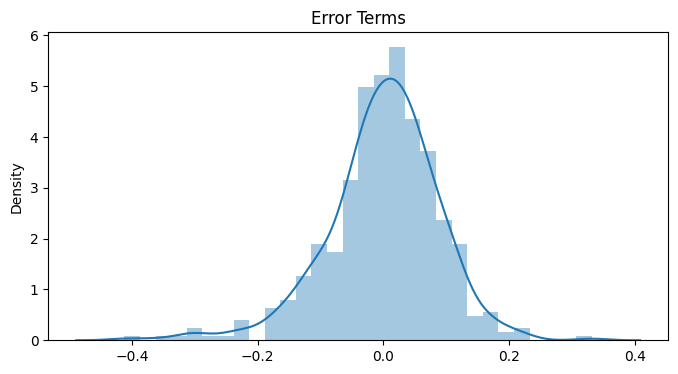

In [56]:
plt.figure(figsize = (8,4))
sns.distplot(y_train - y_train_pred)
plt.title('Error Terms')
plt.show()

**Homoscedasticity**

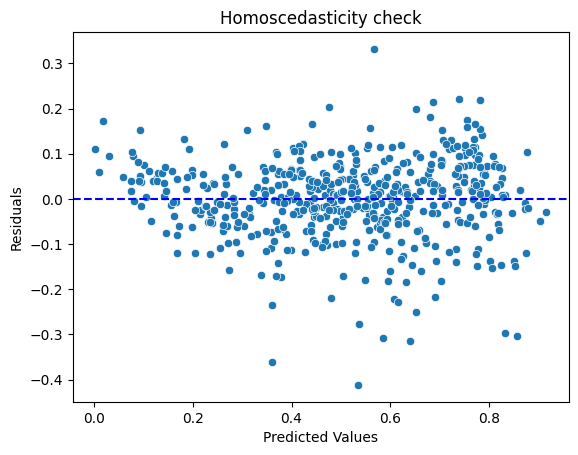

In [57]:
residuals = y_train - y_train_pred
sns.scatterplot(x = y_train_pred, y = residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity check')
plt.axhline(y = 0, color = 'b', linestyle = '--')
plt.show()

- has Homoscedasticity

**Linearity**

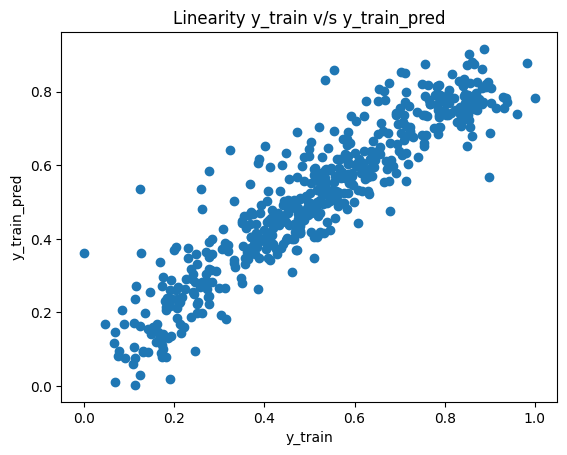

In [58]:
plt.scatter(y_train,y_train_pred)
plt.title('Linearity y_train v/s y_train_pred')
plt.xlabel('y_train')
plt.ylabel('y_train_pred') 
plt.show()

**Making Predictions**

In [59]:
num_vars = ['temp', 'windspeed',"hum",'cnt']
df_test[num_vars]=scaler.transform(df_test[num_vars])

In [60]:
#Dividing X_test and y_test
y_test = df_test.pop('cnt')
X_test = df_test

In [61]:
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,yr,holiday,workingday,temp,hum,windspeed,summer,fall,winter,...,Dec,Monday,Tuesday,Wednesday,Thrusday,Friday,Saturday,Clear,Mist,Light
184,1.0,0,1,0,0.831783,0.657364,0.084219,0,1,0,...,0,0,0,1,0,0,0,0,1,0
535,1.0,1,0,1,0.901354,0.610133,0.153728,1,0,0,...,0,0,0,0,1,0,0,1,0,0
299,1.0,0,0,0,0.511964,0.837699,0.334206,0,0,1,...,0,0,0,0,0,0,1,0,1,0
221,1.0,0,0,1,0.881625,0.437098,0.339570,0,1,0,...,0,0,0,0,0,1,0,1,0,0
152,1.0,0,0,0,0.817246,0.314298,0.537414,1,0,0,...,0,0,0,0,0,0,1,1,0,0


In [62]:
X_test_sm.columns

Index(['const', 'yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'summer', 'fall', 'winter', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
       'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Monday', 'Tuesday', 'Wednesday',
       'Thrusday', 'Friday', 'Saturday', 'Clear', 'Mist', 'Light'],
      dtype='object')

In [63]:
#Dropping the Features which were eliminated during the Training Process
X_test_sm = X_test_sm.drop(['workingday', 'fall', 'Feb', 'Apr', 'May', 'June', 'July', 'Nov', 'Dec', 'Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Clear'],axis=1)

In [64]:
X_test_sm.shape

(219, 14)

In [65]:
# Predict cnt for Test Data
y_test_pred = lm.predict(X_test_sm)

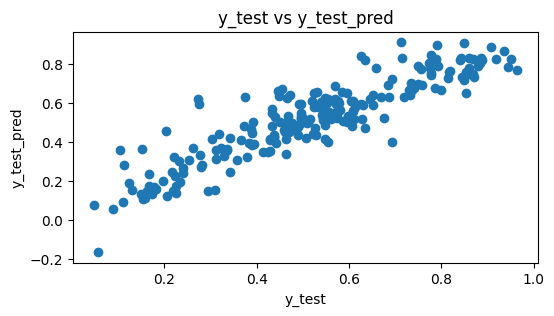

In [66]:
# Plotting y_test and y_pred to understand the spread.
plt.figure(figsize = (6,3))
plt.scatter(y_test,y_test_pred)
plt.title('y_test vs y_test_pred')
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.show()

In [67]:
# Accuracy of Test Model
r2_score(y_test,y_test_pred)

0.811917098529708

Model Accuracy is around 81.1%

In [68]:
#Which variables are significant in predicting the demand for shared bikes
Cofficients = round(lm.params,2)
beta = Cofficients.sort_values(ascending = False)
beta

temp         0.54
const        0.23
yr           0.23
winter       0.14
Sep          0.13
summer       0.10
Aug          0.06
Oct          0.04
Mar          0.02
Mist        -0.05
holiday     -0.09
hum         -0.18
windspeed   -0.19
Light       -0.24
dtype: float64

In [69]:
#How well those variables describe the bike demands
for i in range(0, len(beta)):
    print(beta[i],'*',beta.index[i],end ='')
    print(' + ',end ='')

0.54 * temp + 0.23 * const + 0.23 * yr + 0.14 * winter + 0.13 * Sep + 0.1 * summer + 0.06 * Aug + 0.04 * Oct + 0.02 * Mar + -0.05 * Mist + -0.09 * holiday + -0.18 * hum + -0.19 * windspeed + -0.24 * Light + 

Best fit line equation
0.54 * temp + 0.23 * const + 0.23 * yr + 0.14 * winter + 0.13 * Sep + 0.1 * summer + 0.06 * Aug + 0.04 * Oct + 0.02 * Mar -0.05 * Mist -0.09 * holiday -0.18 * hum -0.19 * windspeed -0.24 * Light

**Insights**
- Mostly temp feature is affecting the bussiness.
- Users most likely to ride bikes in Winter and Summmer not in Rainy.
- Few features like Mist, holiday, hum, windspeed, light effecing the business negatively.
- Bad weather conditions are affecting the users.
- Demand for increased from 2018 to 2019.